# comparing different anomaly detection models

so i've built some features, now let's see which model works best for detecting oxygen anomalies

models to try:
- isolation forest (heard it's good for anomalies)
- one-class svm (might work?)
- local outlier factor (lof)
- simple z-score / iqr based methods
- maybe ensemble?

will test each on the same data and see which catches the anomalies better

loaded 5000 rows


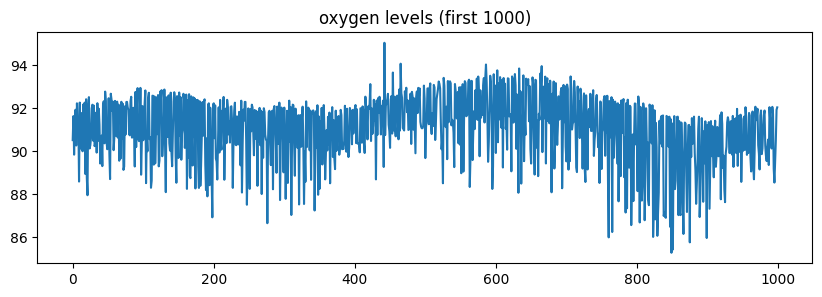

mean: 91.21
std: 1.78
min: 84.57
max: 97.30


In [11]:
# load data and setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# using curated dataset with clean data
df = pd.read_csv('../oxytrace/data/curated_dataset.csv', nrows=5000)
df = df.rename(columns={'Oxygen[%sat]': 'oxygen_saturation'})
print(f'loaded {len(df)} rows')

# quick look at distribution
plt.figure(figsize=(10, 3))
plt.plot(df['oxygen_saturation'].values[:1000])
plt.title('oxygen levels (first 1000)')
plt.show()

print(f"mean: {df['oxygen_saturation'].mean():.2f}")
print(f"std: {df['oxygen_saturation'].std():.2f}")
print(f"min: {df['oxygen_saturation'].min():.2f}")
print(f"max: {df['oxygen_saturation'].max():.2f}")

In [12]:
# create features like before (just the important ones)
def make_features(df):
    oxygen = df['oxygen_saturation'].values
    features = pd.DataFrame()
    
    # rolling stats
    features['roll_mean_5'] = df['oxygen_saturation'].rolling(5, min_periods=1).mean()
    features['roll_std_5'] = df['oxygen_saturation'].rolling(5, min_periods=1).std()
    features['roll_mean_30'] = df['oxygen_saturation'].rolling(30, min_periods=1).mean()
    features['roll_std_30'] = df['oxygen_saturation'].rolling(30, min_periods=1).std()
    
    # difference from rolling mean
    features['diff_from_mean_5'] = df['oxygen_saturation'] - features['roll_mean_5']
    features['diff_from_mean_30'] = df['oxygen_saturation'] - features['roll_mean_30']
    
    # velocity and acceleration
    features['diff_1'] = df['oxygen_saturation'].diff(1).fillna(0)
    features['velocity'] = features['diff_1']
    features['acceleration'] = features['diff_1'].diff(1).fillna(0)
    
    # lag features
    features['lag_1'] = df['oxygen_saturation'].shift(1).fillna(df['oxygen_saturation'].iloc[0])
    features['lag_5'] = df['oxygen_saturation'].shift(5).fillna(df['oxygen_saturation'].iloc[0])
    
    # spike detection
    mean = oxygen.mean()
    std = oxygen.std()
    features['spike'] = (np.abs(oxygen - mean) > 3 * std).astype(int)
    
    return features.fillna(0)

X = make_features(df)
print(f'created {X.shape[1]} features')
print(X.head())

created 12 features
   roll_mean_5  roll_std_5  roll_mean_30  roll_std_30  diff_from_mean_5  \
0    90.521339    0.000000     90.521339     0.000000          0.000000   
1    91.080444    0.790694     91.080444     0.790694          0.559105   
2    90.668584    0.906358     90.668584     0.906358         -0.823720   
3    90.845833    0.820564     90.845833     0.820564          0.531746   
4    91.063707    0.861591     91.063707     0.861591          0.871497   

   diff_from_mean_30    diff_1  velocity  acceleration      lag_1      lag_5  \
0           0.000000  0.000000  0.000000      0.000000  90.521339  90.521339   
1           0.559105  1.118210  1.118210      1.118210  90.521339  90.521339   
2          -0.823720 -1.794685 -1.794685     -2.912895  91.639549  90.521339   
3           0.531746  1.532715  1.532715      3.327400  89.844864  90.521339   
4           0.871497  0.557625  0.557625     -0.975090  91.377579  90.521339   

   spike  
0      0  
1      0  
2      0  
3   

In [13]:
# scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f'scaled features: {X_scaled.shape}')

scaled features: (5000, 12)


isolation forest found 250 anomalies (5.0%)


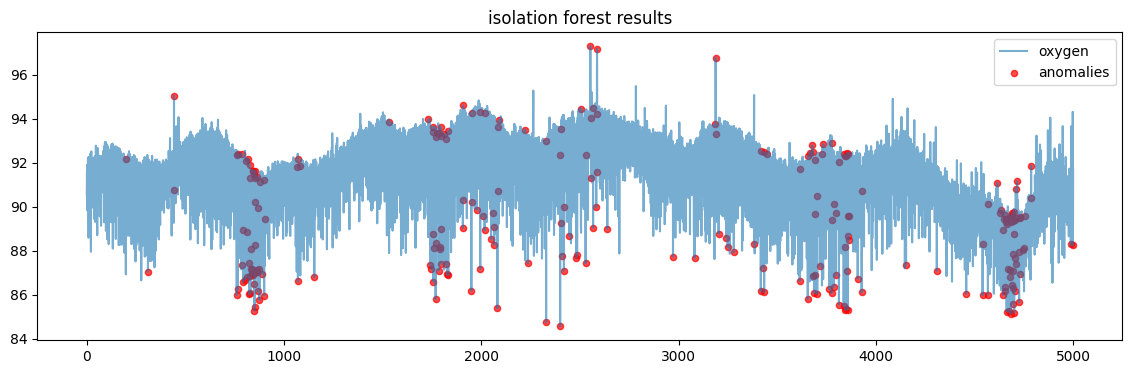

In [14]:
# test 1: isolation forest
iso = IsolationForest(contamination=0.05, random_state=42)
iso_pred = iso.fit_predict(X_scaled)
iso_anomalies = (iso_pred == -1)
print(f'isolation forest found {iso_anomalies.sum()} anomalies ({iso_anomalies.sum()/len(df)*100:.1f}%)')

# plot
plt.figure(figsize=(14, 4))
plt.plot(df['oxygen_saturation'].values, alpha=0.6, label='oxygen')
plt.scatter(np.where(iso_anomalies)[0], df['oxygen_saturation'].values[iso_anomalies], 
            c='red', s=20, label='anomalies', alpha=0.7)
plt.title('isolation forest results')
plt.legend()
plt.show()

one-class svm found 247 anomalies (4.9%)


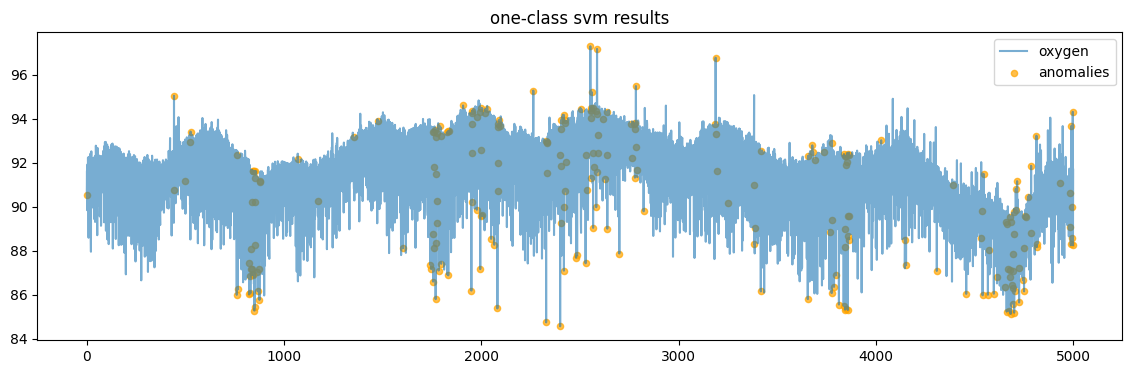

In [15]:
# test 2: one-class svm
# this might be slow...
svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
svm_pred = svm.fit_predict(X_scaled)
svm_anomalies = (svm_pred == -1)
print(f'one-class svm found {svm_anomalies.sum()} anomalies ({svm_anomalies.sum()/len(df)*100:.1f}%)')

plt.figure(figsize=(14, 4))
plt.plot(df['oxygen_saturation'].values, alpha=0.6, label='oxygen')
plt.scatter(np.where(svm_anomalies)[0], df['oxygen_saturation'].values[svm_anomalies], 
            c='orange', s=20, label='anomalies', alpha=0.7)
plt.title('one-class svm results')
plt.legend()
plt.show()

lof found 250 anomalies (5.0%)


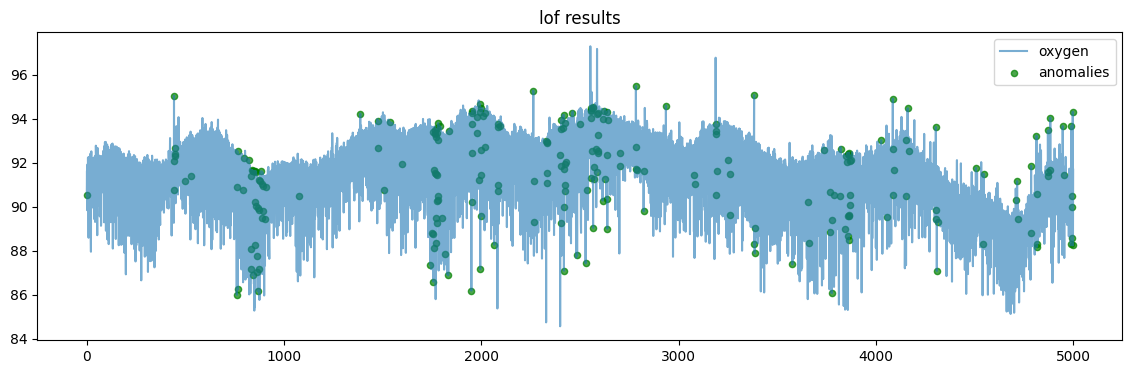

In [16]:
# test 3: local outlier factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_pred = lof.fit_predict(X_scaled)
lof_anomalies = (lof_pred == -1)
print(f'lof found {lof_anomalies.sum()} anomalies ({lof_anomalies.sum()/len(df)*100:.1f}%)')

plt.figure(figsize=(14, 4))
plt.plot(df['oxygen_saturation'].values, alpha=0.6, label='oxygen')
plt.scatter(np.where(lof_anomalies)[0], df['oxygen_saturation'].values[lof_anomalies], 
            c='green', s=20, label='anomalies', alpha=0.7)
plt.title('lof results')
plt.legend()
plt.show()

z-score found 22 anomalies (0.4%)


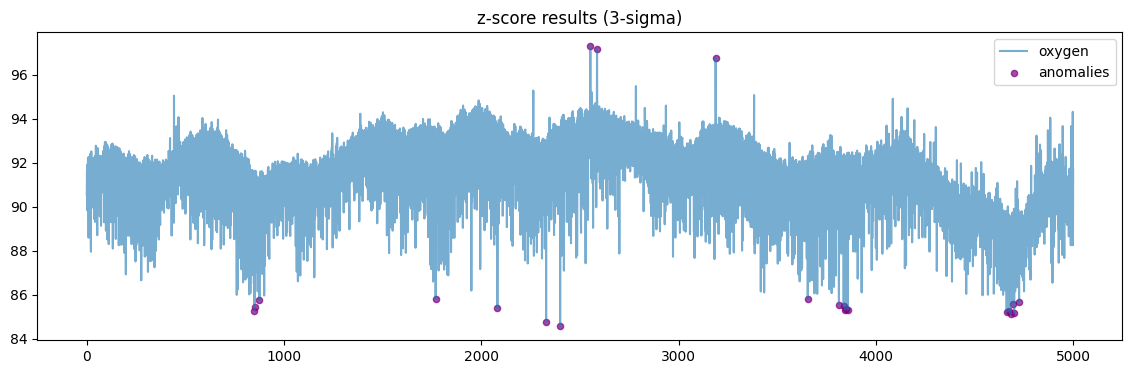

In [17]:
# test 4: simple z-score method
oxygen = df['oxygen_saturation'].values
z_scores = np.abs((oxygen - oxygen.mean()) / oxygen.std())
zscore_anomalies = z_scores > 3  # standard 3-sigma rule
print(f'z-score found {zscore_anomalies.sum()} anomalies ({zscore_anomalies.sum()/len(df)*100:.1f}%)')

plt.figure(figsize=(14, 4))
plt.plot(oxygen, alpha=0.6, label='oxygen')
plt.scatter(np.where(zscore_anomalies)[0], oxygen[zscore_anomalies], 
            c='purple', s=20, label='anomalies', alpha=0.7)
plt.title('z-score results (3-sigma)')
plt.legend()
plt.show()

iqr found 53 anomalies (1.1%)
bounds: [86.49, 96.12]


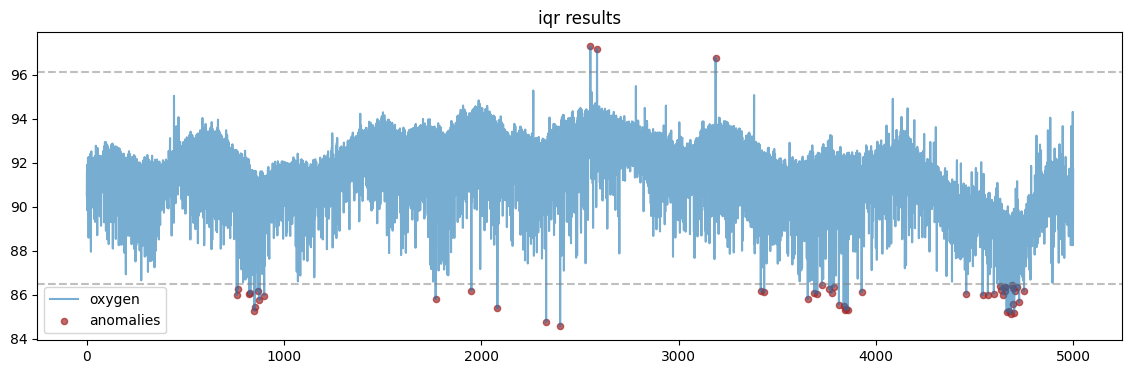

In [18]:
# test 5: iqr method
q1 = np.percentile(oxygen, 25)
q3 = np.percentile(oxygen, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
iqr_anomalies = (oxygen < lower_bound) | (oxygen > upper_bound)
print(f'iqr found {iqr_anomalies.sum()} anomalies ({iqr_anomalies.sum()/len(df)*100:.1f}%)')
print(f'bounds: [{lower_bound:.2f}, {upper_bound:.2f}]')

plt.figure(figsize=(14, 4))
plt.plot(oxygen, alpha=0.6, label='oxygen')
plt.scatter(np.where(iqr_anomalies)[0], oxygen[iqr_anomalies], 
            c='brown', s=20, label='anomalies', alpha=0.7)
plt.axhline(lower_bound, c='gray', linestyle='--', alpha=0.5)
plt.axhline(upper_bound, c='gray', linestyle='--', alpha=0.5)
plt.title('iqr results')
plt.legend()
plt.show()

anomaly counts:
  isolation_forest: 250 (5.0%)
  one_class_svm: 247 (4.9%)
  lof: 250 (5.0%)
  z_score: 22 (0.4%)
  iqr: 53 (1.1%)


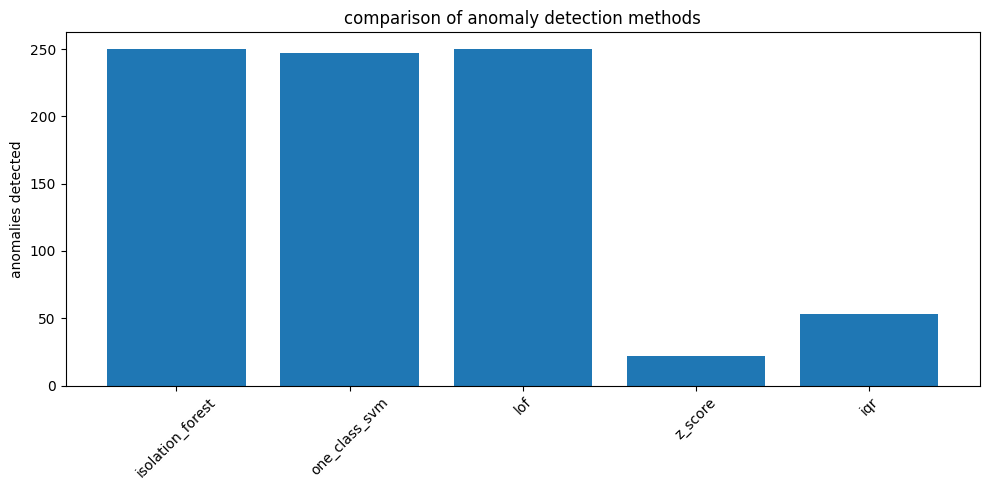

In [19]:
# compare all methods
results = {
    'isolation_forest': iso_anomalies.sum(),
    'one_class_svm': svm_anomalies.sum(),
    'lof': lof_anomalies.sum(),
    'z_score': zscore_anomalies.sum(),
    'iqr': iqr_anomalies.sum()
}

print('anomaly counts:')
for method, count in results.items():
    print(f'  {method}: {count} ({count/len(df)*100:.1f}%)')

# plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(results.keys(), results.values())
ax.set_ylabel('anomalies detected')
ax.set_title('comparison of anomaly detection methods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

ensemble (>=2 votes) found 216 anomalies (4.3%)


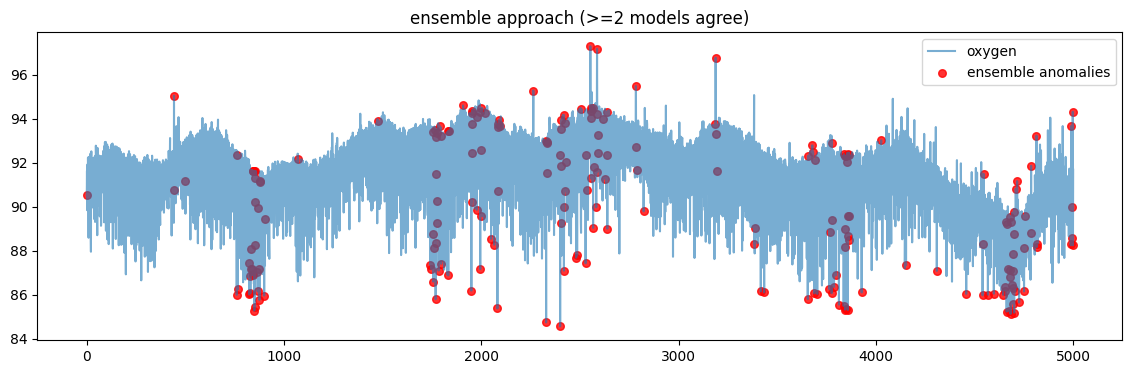


vote distribution:
  0 votes: 4517 (90.3%)
  1 votes: 267 (5.3%)
  2 votes: 120 (2.4%)
  3 votes: 69 (1.4%)
  4 votes: 27 (0.5%)
  5 votes: 0 (0.0%)


In [20]:
# what if we combine them? voting approach
# if 2 or more methods agree, call it an anomaly
votes = (iso_anomalies.astype(int) + 
         svm_anomalies.astype(int) + 
         lof_anomalies.astype(int) + 
         zscore_anomalies.astype(int) + 
         iqr_anomalies.astype(int))

ensemble_anomalies = votes >= 2  # at least 2 methods agree
print(f'ensemble (>=2 votes) found {ensemble_anomalies.sum()} anomalies ({ensemble_anomalies.sum()/len(df)*100:.1f}%)')

plt.figure(figsize=(14, 4))
plt.plot(oxygen, alpha=0.6, label='oxygen')
plt.scatter(np.where(ensemble_anomalies)[0], oxygen[ensemble_anomalies], 
            c='red', s=30, label='ensemble anomalies', alpha=0.8)
plt.title('ensemble approach (>=2 models agree)')
plt.legend()
plt.show()

# show vote distribution
print(f'\nvote distribution:')
for v in range(6):
    count = (votes == v).sum()
    print(f'  {v} votes: {count} ({count/len(df)*100:.1f}%)')

## observations

- **isolation forest** seems pretty good, catches a decent amount without being too aggressive
- **one-class svm** is slower but finds similar patterns
- **lof** is interesting, catches more local anomalies
- **z-score** and **iqr** are simple and fast but might miss some context

the **ensemble approach** looks promising - when multiple models agree, we can be more confident it's actually an anomaly

maybe i should implement both:
- statistical detector (z-score/iqr) for simple/fast detection
- ml-based detector (isolation forest or ensemble) for more sophisticated detection
- ensemble detector that combines multiple models with voting

that way users can choose based on their needs (speed vs accuracy)